In [22]:
# Importing packages
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
import xgboost as xgb

# 1. Retrieving STI history data from yahoo finance
### -Retrieving history of STI as ticker and extract past history from it
### -History extracted consist of every record yahoo finance has, with period set as max
### -Dividends and stock splits are dropped since they are of no used

In [23]:
# Loading STI's history into a dataframe
sti= yf.Ticker("^sti")
sti_df = sti.history(period='max')
sti_df.drop(["Dividends","Stock Splits"], axis=1, inplace=True)
sti_df

,Open,High,Low,Close,Volume
Date,,,,,
1987-12-28,824.400024,824.400024,824.400024,824.400024,0
1987-12-29,810.900024,810.900024,810.900024,810.900024,0
1987-12-30,823.200012,823.200012,823.200012,823.200012,0
1988-01-04,833.599976,833.599976,833.599976,833.599976,0
1988-01-05,879.299988,879.299988,879.299988,879.299988,0
...,...,...,...,...,...
2022-11-28,3241.689941,3248.689941,3221.889893,3240.060059,234267900
2022-11-29,3235.340088,3277.010010,3232.379883,3276.360107,261703800
2022-11-30,3279.860107,3290.560059,3270.030029,3290.489990,460598500


# 2. Exploratory data analysis and feature engineering

## 2.1 Checking any missing data or null values and correlation between columns


In [24]:
# To have a quick understand of the data
sti_df.describe() # Some volume values are 0 which does not make sense and will be remove later on

,Open,High,Low,Close,Volume
count,8725.000000,8725.000000,8725.000000,8725.000000,8.725000e+03
mean,2350.624397,2362.311594,2337.971800,2350.047382,9.993543e+07
std,749.055896,751.932317,745.681364,748.782332,1.248052e+08
min,805.140015,809.869995,800.270020,805.039978,0.000000e+00
25%,1679.479980,1692.699951,1665.540039,1679.390015,0.000000e+00
50%,2301.800049,2311.699951,2287.699951,2300.699951,3.536320e+07
75%,3089.909912,3104.250000,3074.389893,3089.489990,1.888275e+08
max,3899.290039,3906.159912,3852.689941,3875.770020,1.472752e+09


In [25]:
# Checking of na present
sti_df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

# 2.2 Featured enginerring
### Close will be used as main focus for prediction. The following list of indicators will be used to create new features:
#### 1. Exponential moving average (EMA)
#### 2. Moving average convergence/divergence (MACD)
#### 3. Stochastic
#### 4. Force index

## 2.2.1 Creating functions to input features. 
### Functions created are able to calculate with different input range of period such as from 2 periods to 100 periods and above. 
### Periods here refers to timeframe being looked at such as days, hours or minutes.
### For this model, day is used as the period.

In [26]:
def ema(file_name, period, price, smoothing = 2, column_name="ema_period"):
    
    """
    Calculation of EMA is as follows:

    EMA = (price * (smoothing / (1 + duration)) + previous_ema * (1 - (smoothing / (1 + duration)))

    """
    previous_ema = file_name.loc[:period, price].mean() #Getting average to be use as first ema
    
    ema_list = [previous_ema] # Storing first ema as a list and to store other ema values

    for i in range(period-1):
        #Insert 0 into elements before first EMA as first number period of values will not have ema values
        ema_list.insert(0, 0)
    
    # Calculating EMA for the rest
    for row_num in range(period, len(file_name[price])):
        current_price = file_name.loc[row_num, price]
        ema_temp = current_price * (smoothing / (1 + period)) + previous_ema * (1 - (smoothing / (1 + period)))
        previous_ema = ema_temp
        ema_list.append(ema_temp) # Appending of ema into list

    # Adding new column and add ema to it    
    file_name[f"{column_name}_{period}"] = ema_list

def macd(file_name):
    """
    Calculation for MACD as follows:
    MACD = ema_period_12 - ema_period_26
    Signal = ema_period_9 of MACD
    MACD_histogram = MACD - Signal

    Make sure dataframe has column "ema_period_26" and "ema_period_12"
    """

    file_name["macd"] = file_name["ema_period_12"] - file_name["ema_period_26"]
    ema(file_name, period=9, price="macd", column_name="signal_of_macd")
    file_name["macd_histogram"] = file_name["macd"] - file_name["signal_of_macd_9"]


def stochastic(file_name, period = 14, price = "Close"):
    """
    Calculation for stochastic is ((Closing_price - period_low) / (period_high - period_low)) * 100
    Period is define by user, default setting is 14
    Additional 2 columns will be created to show the high and low of the defined period
    """
    file_name[f"high_period_{period}"] = file_name[price].rolling(period).max()
    file_name[f"low_period_{period}"] = file_name[price].rolling(period).min()

    file_name[f"stochastic_period_{period}"] = ((file_name[price] - file_name[f"low_period_{period}"]) / (file_name[f"high_period_{period}"] - file_name[f"low_period_{period}"])) * 100

def force_index(file_name, period = 1, price = "Close"):
    """
    Default price use is "Close"
    Force Index(1) = {Close (current period)  -  Close (prior period)} x Volume
    Force Index(13) = 13-period EMA of Force Index(1)
    Change from yesterday close and today close will be calculate into a new column "close_diff"
    """
    file_name["close_diff"] = file_name[price].diff()
    file_name[f"force_index_period_{period}"] = file_name["close_diff"] * file_name["Volume"]


## 2.2.2 Inputting all features required
### EMA periods chosen are 2, 5, 10, 50
### Stochastic periods chosen are 5, 10, 20
### MACD periods chosen are 26, 12, 9 for fast, slow, signal respectively
### Force index chosen are 1, 2, 5 

In [27]:
# Calculating ema
sti_df.reset_index(inplace=True) # Reset index for easier ema calculation
list_of_ema = [2, 5, 10, 50]
for i in list_of_ema:
    ema(sti_df,i,"Close")

# Calculating stochastic 
for i in [5, 10, 20]:
    stochastic(sti_df, period = i)

# Adding force index period 1 feature into data
force_index(sti_df) # Default for force index, period 1 has to be calculated first before calculating other periods

# Calcuation of force index for period 2 and 5 by using ema on force index period 1
ema(sti_df,2,"force_index_period_1",column_name="force_index")
ema(sti_df,5,"force_index_period_1",column_name="force_index")

# Calculating ema for 12 and 26 periods to calculate macd
ema(sti_df,12,"Close")
ema(sti_df,26,"Close")
macd(sti_df)

In [28]:
sti_df.describe()

,Open,High,Low,Close,Volume,ema_period_2,ema_period_5,ema_period_10,ema_period_50,high_period_5,...,stochastic_period_20,close_diff,force_index_period_1,force_index_2,force_index_5,ema_period_12,ema_period_26,macd,signal_of_macd_9,macd_histogram
count,8725.000000,8725.000000,8725.000000,8725.000000,8.725000e+03,8725.000000,8725.000000,8725.000000,8725.000000,8721.000000,...,8706.000000,8724.000000,8.724000e+03,8.725000e+03,8.725000e+03,8725.000000,8725.000000,8725.000000,8725.000000,8725.000000
mean,2350.624397,2362.311594,2337.971800,2350.047382,9.993543e+07,2349.813500,2349.110505,2347.920837,2338.588962,2374.882861,...,55.430693,0.279085,2.166068e+07,2.160994e+07,2.122337e+07,2347.452828,2344.168800,3.284029,3.266807,0.017222
std,749.055896,751.932317,745.681364,748.782332,1.248052e+08,748.916973,749.422700,750.327256,757.377855,751.211894,...,36.387188,25.179144,5.393826e+09,3.881274e+09,2.544753e+09,750.677996,753.213382,47.657463,42.251529,19.708021
min,805.140015,809.869995,800.270020,805.039978,0.000000e+00,0.000000,0.000000,0.000000,0.000000,856.429993,...,0.000000,-190.369995,-8.988537e+10,-6.008900e+10,-3.994877e+10,0.000000,0.000000,-221.245311,-183.551821,-673.234215
25%,1679.479980,1692.699951,1665.540039,1679.390015,0.000000e+00,1678.598635,1677.239688,1680.211404,1687.430872,1706.130005,...,20.551913,-11.500000,-6.057200e+07,-2.876867e+07,-1.330312e+07,1681.223144,1685.871761,-13.255192,-12.792038,-4.978693
50%,2301.800049,2311.699951,2287.699951,2300.699951,3.536320e+07,2298.932281,2298.578020,2301.163008,2275.732235,2320.899902,...,60.791162,0.475098,0.000000e+00,0.000000e+00,0.000000e+00,2300.605515,2293.480590,4.017638,4.255950,-0.085536
75%,3089.909912,3104.250000,3074.389893,3089.489990,1.888275e+08,3090.475200,3092.223910,3092.907394,3100.544565,3116.320068,...,91.148311,12.882599,2.158042e+08,2.308111e+08,2.084596e+08,3093.574105,3095.347488,21.098501,20.051119,4.875288
max,3899.290039,3906.159912,3852.689941,3875.770020,1.472752e+09,3860.645022,3849.150933,3818.500405,3674.783315,3875.770020,...,100.000000,191.669922,9.042893e+10,6.498969e+10,3.486305e+10,3806.921409,3740.609670,898.894496,854.767125,688.559998


## 2.2.3 Calculating change in features from previous day
### Traditionally trend or change in indicators from previous days are observed to predict trend in stocks
### Here, the change in indicators from previous day to current day are used as features
### Difference between the closing price and EMA of 5, 10, 50 are used to used as features too

In [29]:
# Calculating change of ema period 5, 10, 50
sti_df["ema_period_5_diff"] = sti_df["ema_period_5"].diff()
sti_df["ema_period_10_diff"] = sti_df["ema_period_10"].diff()
sti_df["ema_period_50_diff"] = sti_df["ema_period_50"].diff()

In [30]:
# Change in force index period 1, 2, 5
sti_df["force_index_2_diff"] = sti_df["force_index_2"].diff()	
sti_df["force_index_5_diff"] = sti_df["force_index_5"].diff()

In [31]:
# Calculate the change from previous to current macd, signal_of_macd, macd histogram as features
sti_df["macd_diff"] = sti_df["macd"].diff()
sti_df["signal_of_macd_9_diff"] = sti_df["signal_of_macd_9"].diff()
sti_df["macd_histogram_diff"] = sti_df["macd_histogram"].diff()

In [32]:
# Difference between "Close" and ema period 5, 10, 50 as features
sti_df["close_ema_5_diff"] = sti_df["Close"] - sti_df["ema_period_5"]
sti_df["close_ema_10_diff"] = sti_df["Close"] - sti_df["ema_period_10"]
sti_df["close_ema_50_diff"] = sti_df["Close"] - sti_df["ema_period_50"]

## 2.2.4 Labeling the classification for prediction and removing data with no volume 
### If closing price for current day is higher than previous day closing price, it will be classify as 0
### If closing price for current day is lower than previous day closing price, it will be classify as 1

In [33]:
# Assigning class "1" or "0", if next day close higher than today will be 1 and if lower will be 0

sti_df.loc[sti_df['close_diff'] > 0, ['Next_day_movement']] = 1
sti_df.loc[sti_df['close_diff'] <= 0, ['Next_day_movement']] = 0

# Shifting the "Next day movement" row up by 1 row for prediction
sti_df['Next_day_movement'] = sti_df['Next_day_movement'].shift(-1)

In [34]:
# Remove data that has no volume/ no trades and reset index
sti_df_clean = sti_df[sti_df["Volume"] > 0].reset_index().dropna() # Dropna is to remove current day record which have no next day movement

sti_df_clean.isna().sum()

index                    0
Date                     0
Open                     0
High                     0
Low                      0
Close                    0
Volume                   0
ema_period_2             0
ema_period_5             0
ema_period_10            0
ema_period_50            0
high_period_5            0
low_period_5             0
stochastic_period_5      0
high_period_10           0
low_period_10            0
stochastic_period_10     0
high_period_20           0
low_period_20            0
stochastic_period_20     0
close_diff               0
force_index_period_1     0
force_index_2            0
force_index_5            0
ema_period_12            0
ema_period_26            0
macd                     0
signal_of_macd_9         0
macd_histogram           0
ema_period_5_diff        0
ema_period_10_diff       0
ema_period_50_diff       0
force_index_2_diff       0
force_index_5_diff       0
macd_diff                0
signal_of_macd_9_diff    0
macd_histogram_diff      0
c

# 3.1 Testing of different classification machine learning

## 3.1.1 Creating a baseline model 
### 3.1.1.1 Using logistic regression model as a baseline for comparing with other models

<AxesSubplot:title={'center':'Number of count of each labels'}, xlabel='Next_day_movement', ylabel='count'>

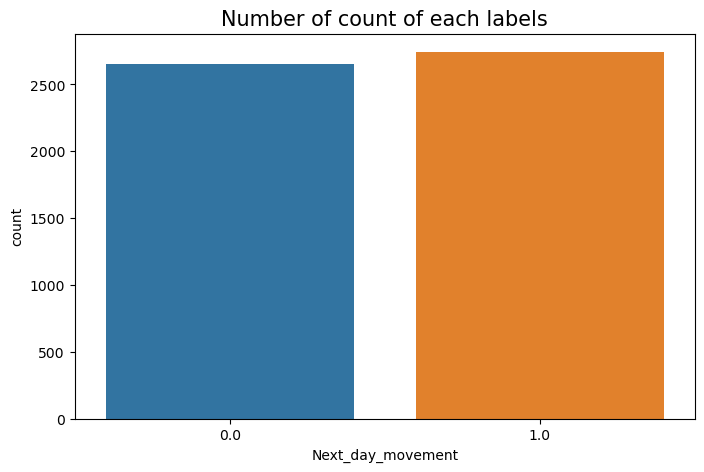

In [35]:
# Finding out whether are the labels equal
fig, sti_corr_ax = plt.subplots(figsize=(8,5))
sti_corr_ax.set_title("Number of count of each labels", fontsize=15)
sns.countplot(data=sti_df_clean, x='Next_day_movement', label = "Count") 

In [36]:
# Separating data after 2022 for validation after train test
sti_df_tt = sti_df_clean.loc[sti_df_clean["Date"] < '2022']
sti_df_validation = sti_df_clean.loc[sti_df_clean["Date"] > '2022']

Labels are seen as balanced so proceed to logistic regression. Accuracy, precision and log loss measurements are used to see how the model is performing

Accuracy score: 0.4995159728944821
Precision score: 0.5344202898550725
Log_loss: 0.6953796365606362


c:\Users\User\anaconda3\envs\mages\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 1.0, 'Heatmap of confusion matrix')

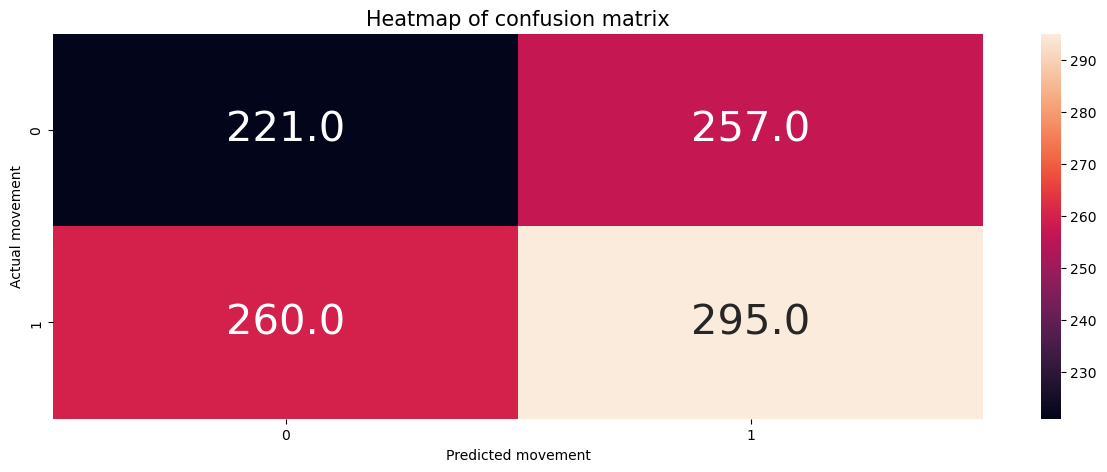

In [37]:
# Logistic regression as a base model
X = sti_df_tt[['ema_period_2', 'ema_period_5', 'ema_period_10', 'ema_period_50',
       'high_period_5', 'low_period_5', 'stochastic_period_5',
       'high_period_10', 'low_period_10', 'stochastic_period_10',
       'high_period_20', 'low_period_20', 'stochastic_period_20', 'close_diff',
       'force_index_period_1', 'force_index_2', 'force_index_5',
       'ema_period_12', 'ema_period_26', 'macd', 'signal_of_macd_9',
       'macd_histogram', 'ema_period_5_diff', 'ema_period_10_diff',
       'ema_period_50_diff', 'force_index_2_diff', 'force_index_5_diff',
       'macd_diff', 'signal_of_macd_9_diff', 'macd_histogram_diff',
       'close_ema_5_diff', 'close_ema_10_diff', 'close_ema_50_diff']]
y = sti_df_tt["Next_day_movement"]

# 80% of the data to be training set while 20% of the data to be test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 111)

# Scale and fit the train and test data sets
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Initialise logistic regression and fitting into model
clf_lr = LogisticRegression(random_state=111)
clf_lr.fit(X_train, y_train)

# Predicting y values from X_test
y_pred_clf_lr = clf_lr.predict(X_test)

# Comparing predicted y values from predicted and actual
print("Accuracy score:",accuracy_score(y_test, y_pred_clf_lr))
print("Precision score:",precision_score(y_test, y_pred_clf_lr))
print("Log_loss:",log_loss(y_test, clf_lr.predict_proba(X_test)[:,1]))
    
# Heatmap of the confusion matrix
cm = confusion_matrix(y_test, y_pred_clf_lr)
fig, heatmap_cm = plt.subplots(figsize=(15,5))
sns.heatmap(cm, annot=True, fmt=".1f", ax=heatmap_cm, annot_kws={"fontsize":30})
heatmap_cm.set(xlabel="Predicted movement", ylabel="Actual movement")
heatmap_cm.set_title("Heatmap of confusion matrix", fontsize=15)

All scores and matrix shows model is predicting randomly. 
Plotting and calculating AUC score to find any possibility of improving treshold.

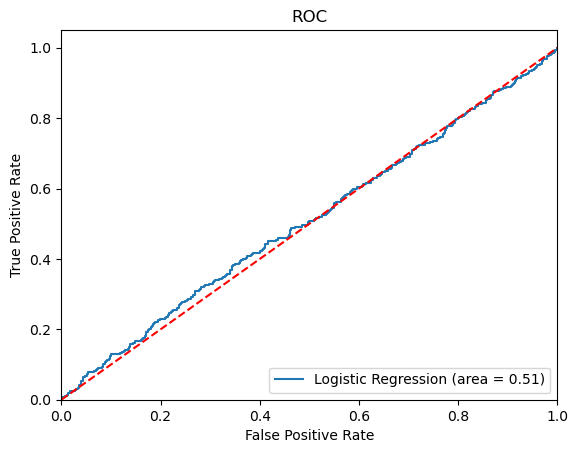

In [38]:
# Calculating and plotting of area under curve(AUC)
fpr, tpr, thresholds = roc_curve(y_test, clf_lr.predict_proba(X_test)[:,1]) 
area_under_curve = roc_auc_score(y_test, clf_lr.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % area_under_curve)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### 3.1.1.2 Changing labels from closing price to ema period of 5
AUC show no way to improve the treshold or model. So the label will be changed from closing price to ema period of 5

<AxesSubplot:title={'center':'Close and exponential moving average of 5 days'}, xlabel='Date', ylabel='Price'>

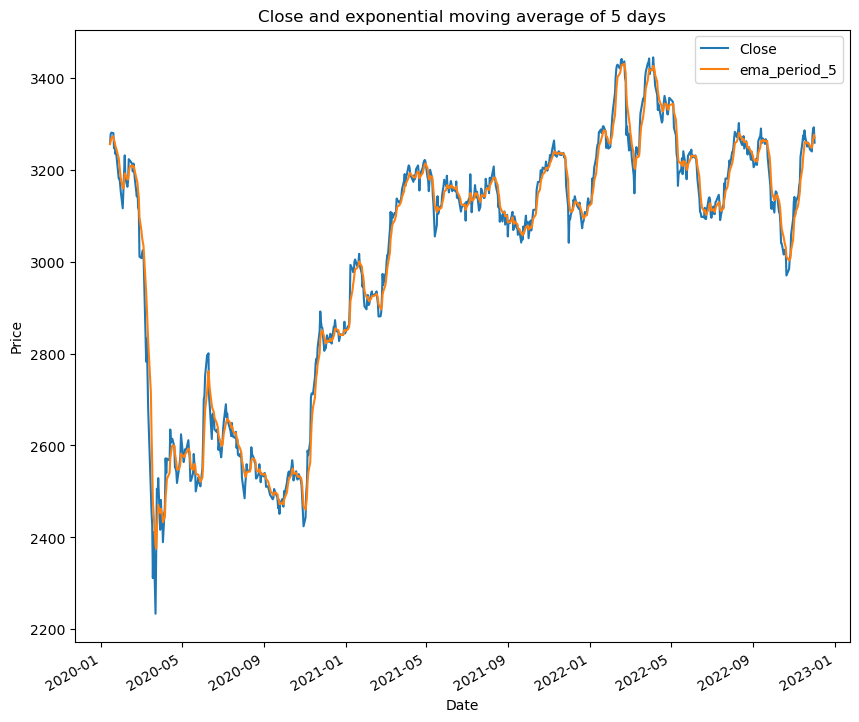

In [39]:
# Plotting of closing price and ema_period_5
sti_df.loc[8000:].plot(figsize=(10,9), 
                            x="Date", 
                            y=["Close", "ema_period_5"],
                            ylabel="Price",
                            xlabel="Date",
                            title="Close and exponential moving average of 5 days")

In [40]:
# Classification based on change in ema period of 5 days, 1 for positive change and 0 for negative change
sti_df.loc[sti_df['ema_period_5_diff'] > 0, ['Next_day_movement']] = 1
sti_df.loc[sti_df['ema_period_5_diff'] <= 0, ['Next_day_movement']] = 0

# Shifting the current day movement to previous day to put it as label
sti_df['Next_day_movement'] = sti_df['Next_day_movement'].shift(-1)

# Remove data that has no volume/ no trades and reset index
sti_df_clean = sti_df[sti_df["Volume"] > 0].reset_index().dropna() # Dropna is to remove current day record which have no next day movement


In [41]:
# Separating data after 2022 for validation after train test
sti_df_tt = sti_df_clean.loc[sti_df_clean["Date"] < '2022']
sti_df_validation = sti_df_clean.loc[sti_df_clean["Date"] > '2022']

c:\Users\User\anaconda3\envs\mages\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Next_day_movement', ylabel='count'>

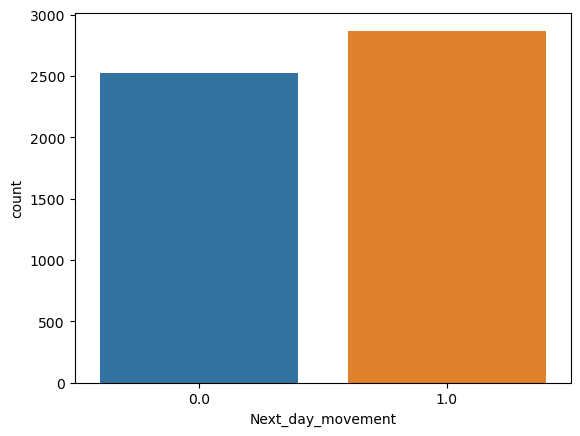

In [42]:
# Checking if the labels are equal
sns.countplot(sti_df_clean['Next_day_movement'], label = "Count") 

c:\Users\User\anaconda3\envs\mages\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy score: 0.7483059051306873
Precision score: 0.7695035460992907
Log_loss: 0.508875210978332


Text(0.5, 1.0, 'Heatmap of confusion matrix')

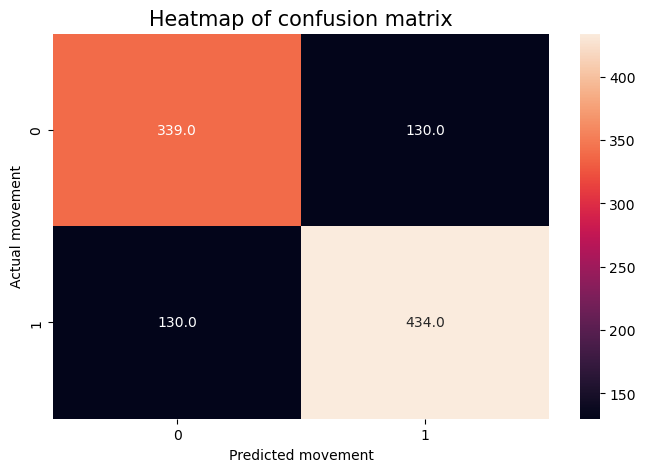

In [43]:
# Logistic regression as a base model to test can ema_period_5 can be used or not
X = sti_df_tt[['ema_period_2', 'ema_period_5', 'ema_period_10', 'ema_period_50',
       'high_period_5', 'low_period_5', 'stochastic_period_5',
       'high_period_10', 'low_period_10', 'stochastic_period_10',
       'high_period_20', 'low_period_20', 'stochastic_period_20', 'close_diff',
       'force_index_period_1', 'force_index_2', 'force_index_5',
       'ema_period_12', 'ema_period_26', 'macd', 'signal_of_macd_9',
       'macd_histogram', 'ema_period_5_diff', 'ema_period_10_diff',
       'ema_period_50_diff', 'force_index_2_diff', 'force_index_5_diff',
       'macd_diff', 'signal_of_macd_9_diff', 'macd_histogram_diff',
       'close_ema_5_diff', 'close_ema_10_diff', 'close_ema_50_diff']]
y = sti_df_tt["Next_day_movement"]

# 80% of the data to be training set while 20% of the data to be test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 111)

# Scale and fit the train and test data sets
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Initialise logistic regression and fitting into model
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)

# Predicting y values from X_test
y_pred_clf_lr = clf_lr.predict(X_test)

# Comparing predicted y values from predicted and actual
print("Accuracy score:",accuracy_score(y_test, y_pred_clf_lr))
print("Precision score:",precision_score(y_test, y_pred_clf_lr))
print("Log_loss:",log_loss(y_test, clf_lr.predict_proba(X_test)[:,1]))
    
# Heatmap of the confusion matrix
cm = confusion_matrix(y_test, y_pred_clf_lr)
fig, heatmap_cm = plt.subplots(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt=".1f", ax=heatmap_cm)
heatmap_cm.set(xlabel="Predicted movement", ylabel="Actual movement")
heatmap_cm.set_title("Heatmap of confusion matrix", fontsize=15)

## 3.1.2 Selecting important features
Using feature importance from random forest to filter features

In [44]:
# Initialise random forest classification
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)

RandomForestClassifier()

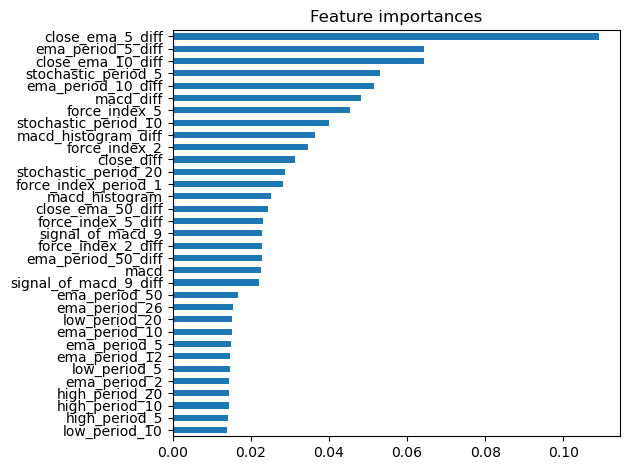

In [45]:
# Plotting features importances as bar chart
features = ['ema_period_2', 'ema_period_5', 'ema_period_10', 'ema_period_50',
       'high_period_5', 'low_period_5', 'stochastic_period_5',
       'high_period_10', 'low_period_10', 'stochastic_period_10',
       'high_period_20', 'low_period_20', 'stochastic_period_20', 'close_diff',
       'force_index_period_1', 'force_index_2', 'force_index_5',
       'ema_period_12', 'ema_period_26', 'macd', 'signal_of_macd_9',
       'macd_histogram', 'ema_period_5_diff', 'ema_period_10_diff',
       'ema_period_50_diff', 'force_index_2_diff', 'force_index_5_diff',
       'macd_diff', 'signal_of_macd_9_diff', 'macd_histogram_diff',
       'close_ema_5_diff', 'close_ema_10_diff', 'close_ema_50_diff']
       
importances = clf_rf.feature_importances_

forest_importances = pd.Series(importances, index=features)
forest_importances.sort_values(ascending=True, inplace=True)

fig, ax = plt.subplots()
forest_importances.plot.barh(ax=ax)
ax.set_title("Feature importances")
fig.tight_layout()


<AxesSubplot:>

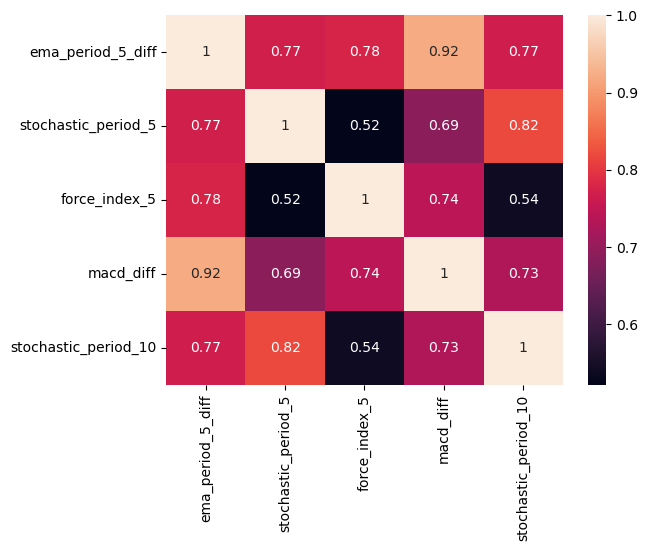

In [46]:
# Slice X and y for test, train
X = sti_df_tt[['ema_period_5_diff', 'stochastic_period_5', 'force_index_5', 'macd_diff', 'stochastic_period_10']]
y = sti_df_tt["Next_day_movement"]

sns.heatmap(X.corr(), annot=True)

## 3.2 Testing of different classification models

In [47]:
# 80% of the data to be training set while 20% of the data to be test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 111)

In [48]:
# Scale and fit the train and test data sets
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [49]:
# Initialise all classification model
clf_lr = LogisticRegression(random_state = 111)
clf_gnb = GaussianNB()
clf_dt = DecisionTreeClassifier(random_state = 111)
clf_knn = KNeighborsClassifier()  # p=2 uses euclidean distance
clf_rf = RandomForestClassifier(random_state = 111) 
clf_svc = SVC(random_state = 111, probability=True) # For predict_proba


LogisticRegression(random_state=111)
Accuracy score: 0.7483059051306873
Precision score: 0.7743682310469314
Log_loss: 0.508222199408583
AUC score: 0.8283241845483826

GaussianNB()
Accuracy score: 0.7328170377541142
Precision score: 0.7562277580071174
Log_loss: 0.9428216367296243
AUC score: 0.8198558877345795

DecisionTreeClassifier(random_state=111)
Accuracy score: 0.6824782187802517
Precision score: 0.7218045112781954
Log_loss: 10.966928362004234
AUC score: 0.6826430159234225

KNeighborsClassifier()
Accuracy score: 0.7212003872216844
Precision score: 0.7446808510638298
Log_loss: 2.326000498728897
AUC score: 0.7750249512316835

RandomForestClassifier(random_state=111)
Accuracy score: 0.7270087124878993
Precision score: 0.7620817843866171
Log_loss: 0.7252241373188919
AUC score: 0.8086845408217272

SVC(probability=True, random_state=111)
Accuracy score: 0.7483059051306873
Precision score: 0.7846441947565543
Log_loss: 0.5443379368688529
AUC score: 0.796908315565032


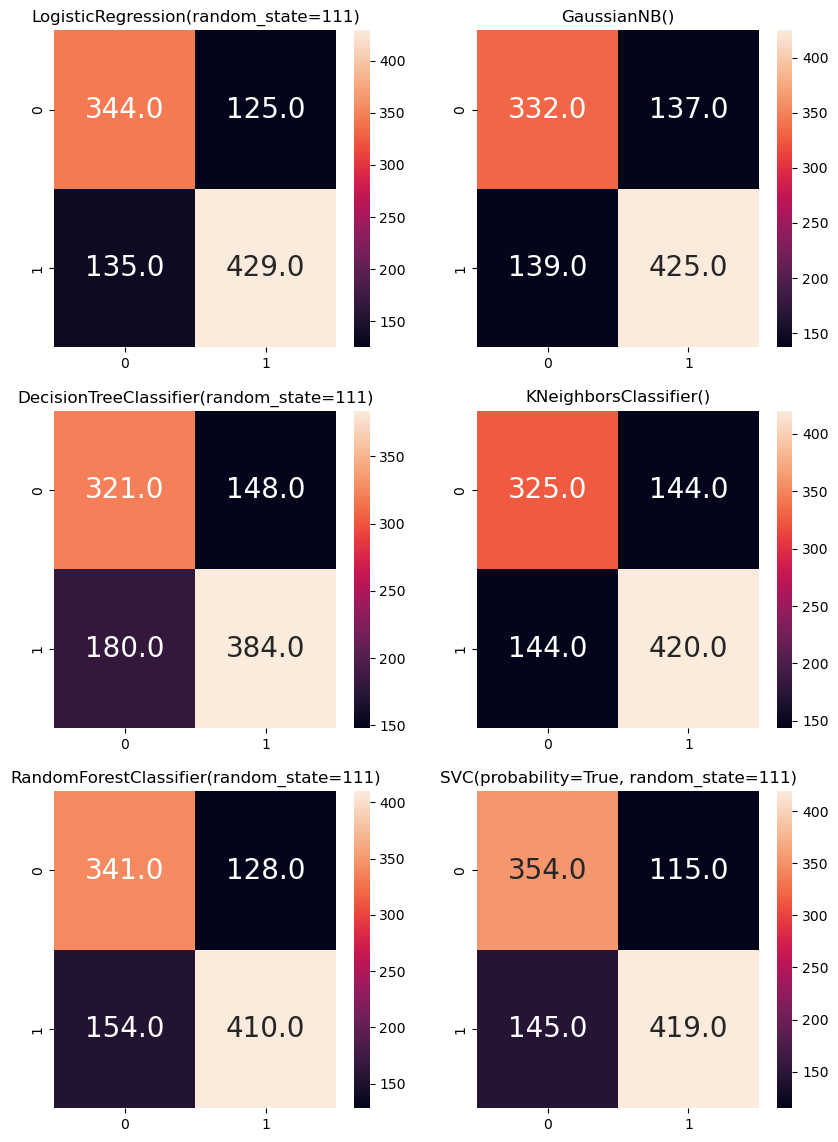

In [50]:
# Fitting train datasets into all model and predicting test set from model
classification_list = [clf_lr, clf_gnb, clf_dt, clf_knn, clf_rf, clf_svc]
num = 1
fig, ax = plt.subplots(3,2,figsize=(10,14))
for algo in classification_list:
    algo.fit(X_train, y_train)
    y_pred = algo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    #Calculating metrics score
    print(f"\n{algo}\nAccuracy score:",accuracy_score(y_test, y_pred))
    print("Precision score:",precision_score(y_test, y_pred))
    print("Log_loss:",log_loss(y_test, algo.predict_proba(X_test)[:,1]))
    print(f"AUC score: {roc_auc_score(y_test, algo.predict_proba(X_test)[:,1])}")
    
    # Plotting of confusion matrix as heatmap
    plt.subplot(3,2,num)
    sns.heatmap(cm, annot=True, fmt=".1f", annot_kws={"fontsize":20})
    heatmap_cm.set(xlabel="Predicted movement", ylabel="Actual movement")
    plt.title(algo, fontsize=12)
    
    num += 1



# 4.1 Optimising ML models

### 4.1.1 Optimising random forest classifier
GridSearchCV is used to optimised the parameters of random forest classification:
<br>
-max_depth
<br>
-criterion
<br>
-n_estimators 

In [51]:
# Storing of metrics values
optimised_metrics_df = pd.DataFrame()

In [52]:
# Optimising random forest classifier using GridSearchCV
param_grid = { 'max_depth' : [1,2,3], 
               'criterion': ['gini','entropy'],
               'n_estimators': [250, 275, 300]
} 
clf_rf_grid = GridSearchCV(clf_rf, param_grid, cv=5, verbose=1)

In [53]:
# Fitting train data into unoptimised random forest model with parameters to be optimised
clf_rf_grid.fit(X_train,y_train) # Takes sometime to run

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=111),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3],
                         'n_estimators': [250, 275, 300]},
             verbose=1)

In [54]:
# Showing what are the best parameters to use
clf_rf_grid.best_params_

{'criterion': 'gini', 'max_depth': 1, 'n_estimators': 275}

Random forest optimised:
Accuracy score: 0.7454017424975798
Precision score: 0.7771639042357275
Log_loss: 0.5444414281075485
AUC score: 0.8020195375705061


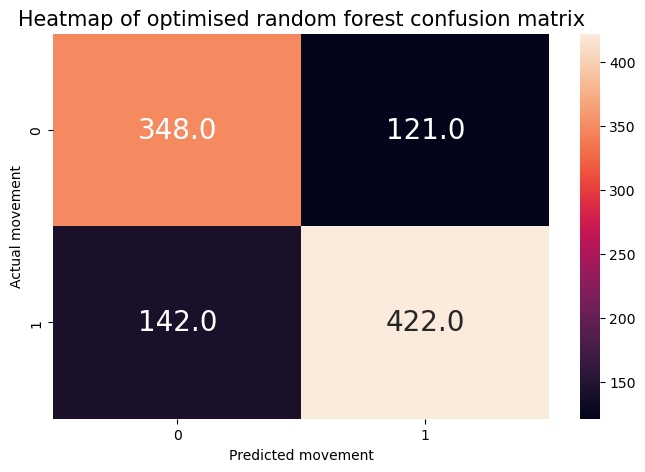

In [55]:
# Testing optimised random forest model
clf_rf_optimised = RandomForestClassifier(criterion='gini', max_depth=1, n_estimators=275, random_state=111)
clf_rf_optimised.fit(X_train, y_train)
y_pred = clf_rf_optimised.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Calculate metrics score
print("Random forest optimised:\nAccuracy score:",accuracy_score(y_test, y_pred))
print("Precision score:",precision_score(y_test, y_pred))
print("Log_loss:",log_loss(y_test, clf_rf_optimised.predict_proba(X_test)[:,1]))
print(f"AUC score: {roc_auc_score(y_test, clf_rf_optimised.predict_proba(X_test)[:,1])}")

# Plotting confusion matrix heatmap
fig, heatmap_cm = plt.subplots(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt=".1f", ax=heatmap_cm, annot_kws={"fontsize":20})
heatmap_cm.set(xlabel="Predicted movement", ylabel="Actual movement")
heatmap_cm.set_title("Heatmap of optimised random forest confusion matrix", fontsize=15)

# Store metrics values into dataframe
optimised_metrics_df["optimised random forest"] = [accuracy_score(y_test, y_pred),
                                                    precision_score(y_test, y_pred),
                                                    log_loss(y_test, clf_rf_optimised.predict_proba(X_test)[:,1]),
                                                    roc_auc_score(y_test, clf_rf_optimised.predict_proba(X_test)[:,1])]


### 4.1.2 Optimising support vector classification (SVC) model
GridSearchCV is used to optimised the parameters of SVC:
<br>
-C
<br>
-criterion


In [56]:
# Optimising SVC model hyperparameters
param_grid = {'C': [0.04, 0.05, 0.06], 
              'gamma': [0.05, 0.06, 0.07]}

grid = GridSearchCV(clf_svc, param_grid, cv=5, verbose=1)

In [57]:
# Fitting train data into unoptimised SVC model with parameters to be optimised
grid.fit(X_train, y_train) # Take some time to run

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=111),
             param_grid={'C': [0.04, 0.05, 0.06], 'gamma': [0.05, 0.06, 0.07]},
             verbose=1)

In [58]:
# Showing what are the best parameters to use
grid.best_params_

{'C': 0.05, 'gamma': 0.06}

SVC optimised
Accuracy score: 0.755082284607938
Precision score: 0.7822141560798548
Log_loss: 0.5287892205548937
AUC score: 0.8197953999001951


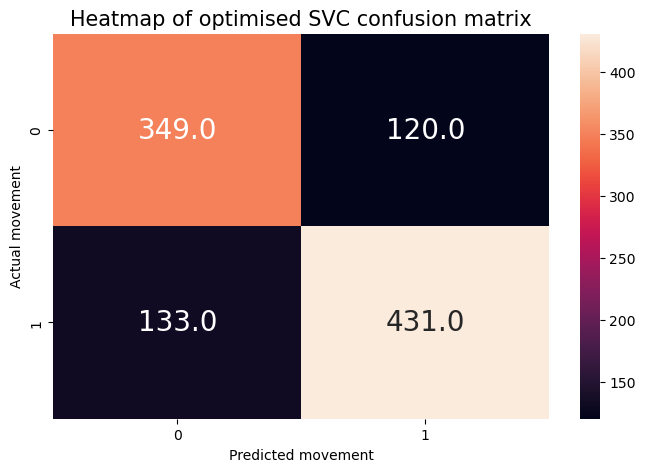

In [60]:
# Testing of optimised SVC model
clf_svc_optimised = SVC(C=0.05, gamma=0.06, probability=True, random_state=111)
clf_svc_optimised.fit(X_train, y_train)
y_pred = clf_svc_optimised.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Calculate metrics score
print("SVC optimised\nAccuracy score:",accuracy_score(y_test, y_pred))
print("Precision score:",precision_score(y_test, y_pred))
print("Log_loss:",log_loss(y_test, clf_svc_optimised.predict_proba(X_test)[:,1]))
print(f"AUC score: {roc_auc_score(y_test, clf_svc_optimised.predict_proba(X_test)[:,1])}") 

# Plotting confusion matrix heatmap
fig, heatmap_cm = plt.subplots(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt=".1f", ax=heatmap_cm, annot_kws={"fontsize":20})
heatmap_cm.set(xlabel="Predicted movement", ylabel="Actual movement")
heatmap_cm.set_title("Heatmap of optimised SVC confusion matrix", fontsize=15)

# Store metrics values into dataframe
optimised_metrics_df["optimised SVC"] = [accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        log_loss(y_test, clf_svc_optimised.predict_proba(X_test)[:,1]),
                                        roc_auc_score(y_test, clf_svc_optimised.predict_proba(X_test)[:,1])]



### 4.1.3 Optimising model using XG booster
GridSearchCV is used to optimised the parameters of XG boost classifier:
<br>
-Learning rate
<br>
-gamma
<br>
-Early stopping rounds

In [61]:
# Optimising XG boost model hyperparameters
# Take some time to run
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', random_state = 111)

param_dict_xgb =  {"learning_rate" : [0.07,0.08,0.09]
                , 'max_depth' : [30,40,50]
                , "eval_metric" : ["error"]
                , "gamma" : [6,7,8]
                , "early_stopping_rounds" : [10,20,40]
                }
                 
grid_model_xgb = GridSearchCV(param_grid= param_dict_xgb , 
                              estimator= clf_xgb, 
                              cv= 5, verbose=1)

xgb_m = grid_model_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=1)



Fitting 5 folds for each of 81 candidates, totalling 405 fits
[0]	validation_0-error:0.26428
[1]	validation_0-error:0.25557
[2]	validation_0-error:0.25169
[3]	validation_0-error:0.25557
[4]	validation_0-error:0.25557
[5]	validation_0-error:0.25847
[6]	validation_0-error:0.25557
[7]	validation_0-error:0.26137
[8]	validation_0-error:0.26041
[9]	validation_0-error:0.25750
[10]	validation_0-error:0.26041
[11]	validation_0-error:0.25847
[12]	validation_0-error:0.25750
[0]	validation_0-error:0.28267
[1]	validation_0-error:0.27590
[2]	validation_0-error:0.26137
[3]	validation_0-error:0.26718
[4]	validation_0-error:0.26718
[5]	validation_0-error:0.26137
[6]	validation_0-error:0.26428
[7]	validation_0-error:0.25847
[8]	validation_0-error:0.25653
[9]	validation_0-error:0.25653
[10]	validation_0-error:0.25557
[11]	validation_0-error:0.25847
[12]	validation_0-error:0.26234
[13]	validation_0-error:0.26137
[14]	validation_0-error:0.25944
[15]	validation_0-error:0.26137
[16]	validation_0-error:0.2546

In [62]:
# Showing what are the best parameters to use
xgb_m.best_params_

{'early_stopping_rounds': 10,
 'eval_metric': 'error',
 'gamma': 7,
 'learning_rate': 0.07,
 'max_depth': 30}

In [63]:
# Testing optimised XGboost model
clf_xgb_optimised = xgb.XGBClassifier(random_state = 111
                , objective = 'binary:logistic'
                , max_depth = 30
                , learning_rate = 0.08
                , eval_metric = "error"
                , gamma = 7
                , early_stopping_rounds = 20
                )
eval_set = [(X_train, y_train), (X_test, y_test)]
clf_xgb_optimised.fit(X_train, y_train, eval_set= eval_set)


[0]	validation_0-error:0.21278	validation_1-error:0.24492
[1]	validation_0-error:0.20625	validation_1-error:0.24492
[2]	validation_0-error:0.20939	validation_1-error:0.24879
[3]	validation_0-error:0.21181	validation_1-error:0.24879
[4]	validation_0-error:0.21254	validation_1-error:0.24782
[5]	validation_0-error:0.20988	validation_1-error:0.24589
[6]	validation_0-error:0.20842	validation_1-error:0.24685
[7]	validation_0-error:0.20915	validation_1-error:0.23814
[8]	validation_0-error:0.20842	validation_1-error:0.24395
[9]	validation_0-error:0.21060	validation_1-error:0.24589
[10]	validation_0-error:0.20842	validation_1-error:0.24105
[11]	validation_0-error:0.20867	validation_1-error:0.24008
[12]	validation_0-error:0.20939	validation_1-error:0.24008
[13]	validation_0-error:0.20915	validation_1-error:0.24201
[14]	validation_0-error:0.21036	validation_1-error:0.24105
[15]	validation_0-error:0.20794	validation_1-error:0.24685
[16]	validation_0-error:0.20697	validation_1-error:0.25169
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=20, enable_categorical=False,
              eval_metric='error', feature_types=None, gamma=7, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.08, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=30, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=111, ...)

Optimised XG boost
Accuracy score: 0.7618586640851888
Precision score: 0.7912087912087912
Log_loss: 0.5668255588957555
AUC score: 0.8257156466905594


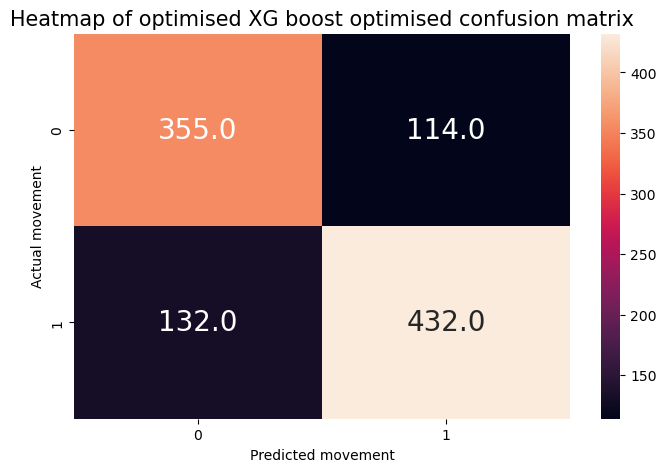

In [64]:
# Calculate metrics score
y_pred = clf_xgb_optimised.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Optimised XG boost\nAccuracy score:",accuracy_score(y_test, y_pred))
print("Precision score:",precision_score(y_test, y_pred))
print("Log_loss:",log_loss(y_test, clf_xgb_optimised.predict_proba(X_test)[:,1]))
print(f"AUC score: {roc_auc_score(y_test, clf_xgb_optimised.predict_proba(X_test)[:,1])}") 


# Plotting confusion matrix heatmap
fig, heatmap_cm = plt.subplots(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt=".1f", ax=heatmap_cm, annot_kws={"fontsize":20})
heatmap_cm.set(xlabel="Predicted movement", ylabel="Actual movement")
heatmap_cm.set_title("Heatmap of optimised XG boost optimised confusion matrix", fontsize=15)

# Store metrics values into dataframe
optimised_metrics_df["optimised XB boost"] = [accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        log_loss(y_test, clf_xgb_optimised.predict_proba(X_test)[:,1]),
                                        roc_auc_score(y_test, clf_xgb_optimised.predict_proba(X_test)[:,1])]

### 4.1.4 Stacking model together in one ensemble model
Models used here are the best four performing models: XGBClassifier, RandomForestClassifier, SCV and LogisticRegression
<br>
Stacked model will be compare with voting classifier model

In [65]:
from sklearn.ensemble import StackingClassifier

In [66]:
# Inputting estimator to be used
estimators = [("clf_xgb_optimised", xgb.XGBClassifier(random_state = 111, objective = 'binary:logistic', max_depth = 30, learning_rate = 0.08, eval_metric = "error", gamma = 7)),
            ("clf_rf_optimised", RandomForestClassifier(criterion='gini', max_depth=1, n_estimators=275, random_state=111)),
            ("clf_svc_optimised", SVC(C=0.05, gamma=0.06, probability=True, random_state=111)),
            ("clf_lr", LogisticRegression())
]

Stacking classifier
Accuracy score: 0.7512100677637947
Precision score: 0.7869158878504673
Log_loss: 0.555663253562256
AUC score: 0.7847275779158915


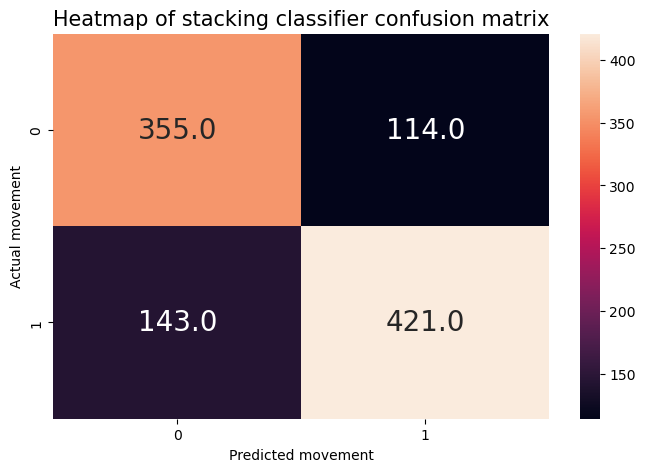

In [67]:
# Testing of ensemble model
clf_stack = StackingClassifier(estimators=estimators, final_estimator=SVC(C=10, gamma=20, probability=True, random_state=111))
clf_stack.fit(X_train, y_train)
y_pred = clf_stack.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Calculate metrics score
y_pred = clf_stack.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Stacking classifier\nAccuracy score:",accuracy_score(y_test, y_pred))
print("Precision score:",precision_score(y_test, y_pred))
print("Log_loss:",log_loss(y_test, clf_stack.predict_proba(X_test)[:,1]))
print(f"AUC score: {roc_auc_score(y_test, clf_stack.predict_proba(X_test)[:,1])}") 

# Plotting confusion matrix heatmap
fig, heatmap_cm = plt.subplots(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt=".1f", ax=heatmap_cm, annot_kws={"fontsize":20})
heatmap_cm.set(xlabel="Predicted movement", ylabel="Actual movement")
heatmap_cm.set_title("Heatmap of stacking classifier confusion matrix", fontsize=15)

# Store metrics values into dataframe
optimised_metrics_df["Stacking model"] = [accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        log_loss(y_test, clf_stack.predict_proba(X_test)[:,1]),
                                        roc_auc_score(y_test,clf_stack.predict_proba(X_test)[:,1])]

### 4.1.5 Stacking model together using voting classifier

In [68]:
# create the sub models
estimators = []

clf_lr = LogisticRegression()
estimators.append(('LogReg', clf_lr))

clf_rf_optimised = RandomForestClassifier(criterion='gini', max_depth=1, n_estimators=275, random_state=111)
estimators.append(('RanF', clf_rf_optimised))

clf_svc = SVC(C=0.05, gamma=0.06, probability=True, random_state=111)
estimators.append(('SVC', clf_svc))

clf_xgb_optimised = xgb.XGBClassifier(random_state = 111, objective = 'binary:logistic', max_depth = 30, learning_rate = 0.08, eval_metric = "error", gamma = 7)
estimators.append(('xgb', clf_xgb_optimised))

Accuracy score: 0.7531461761858664
Precision score: 0.7866419294990723


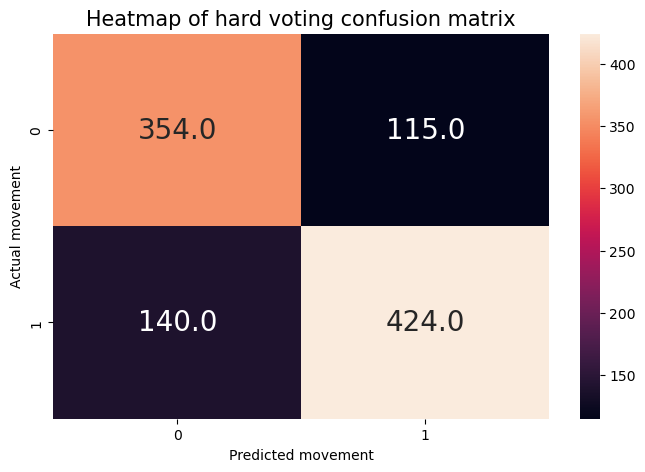

In [69]:
# Using VotingClassifier() to build ensemble model with Hard Voting
clf_hv = VotingClassifier(estimators)
clf_hv.fit(X_train,y_train)

# Calculate metrics score
y_pred = clf_hv.predict(X_test) 
print("Accuracy score:", accuracy_score(y_test, y_pred))   
print("Precision score:",precision_score(y_test, y_pred))   

# Plotting confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
fig, heatmap_cm = plt.subplots(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt=".1f",  ax=heatmap_cm, annot_kws={"fontsize":20})
heatmap_cm.set(xlabel="Predicted movement", ylabel="Actual movement")
heatmap_cm.set_title("Heatmap of hard voting confusion matrix", fontsize=15)

# Store metrics values into dataframe
optimised_metrics_df["Voting classifier"] = [accuracy_score(y_test, y_pred),
                                            precision_score(y_test, y_pred),
                                            np.nan,
                                            np.nan]

## 4.2 Plotting and comparing models

<AxesSubplot:title={'center':'Metrics comparision of models'}, xlabel='Metrics measurement used', ylabel='Measurement'>

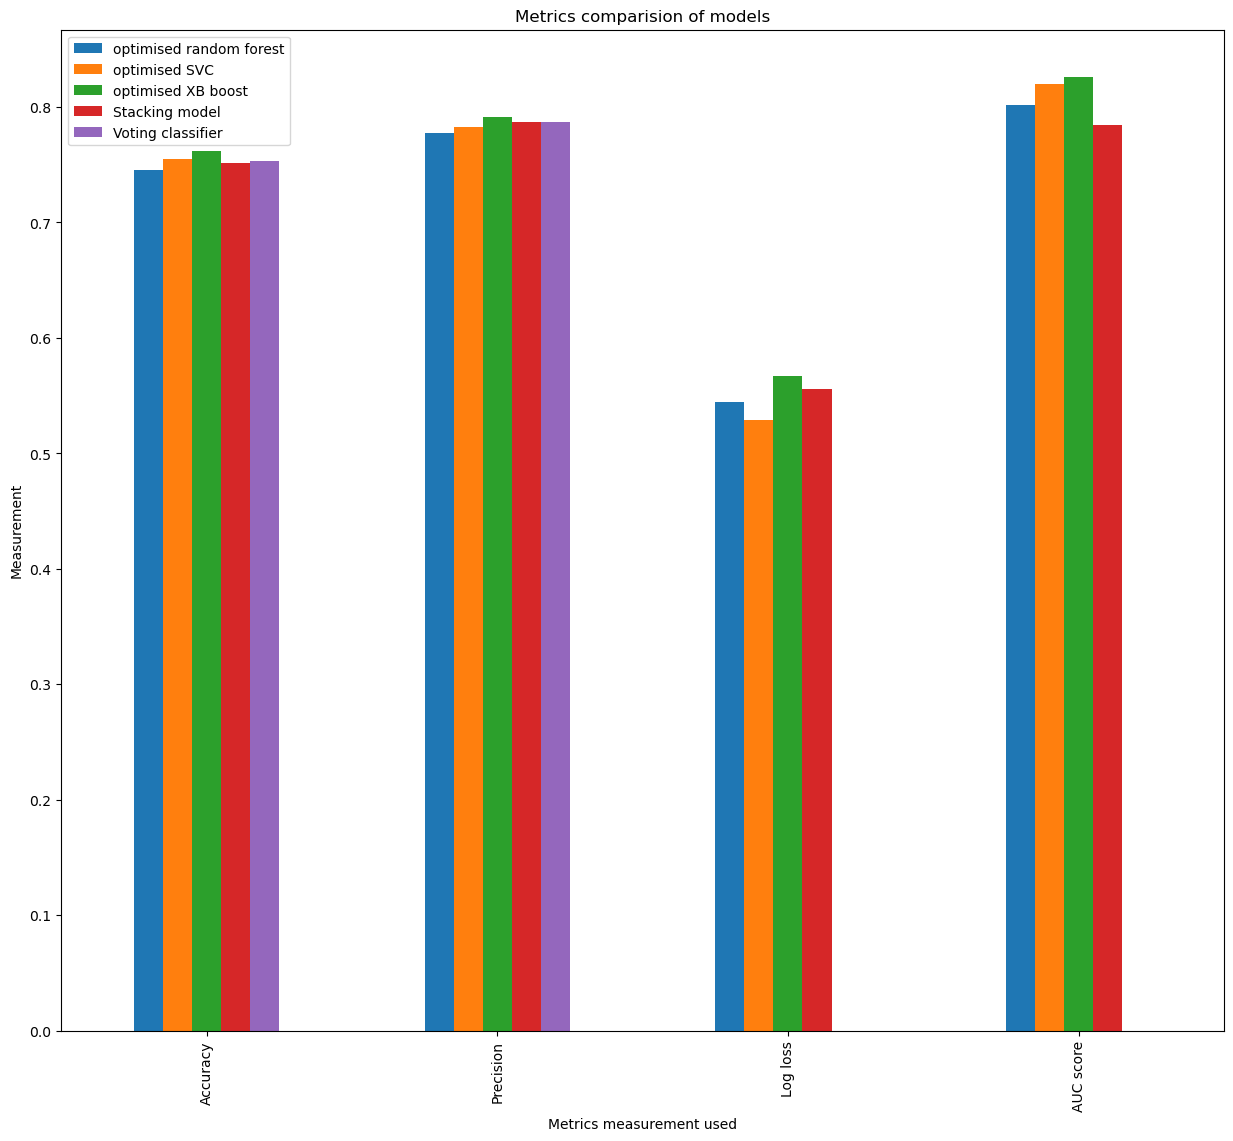

In [94]:
# Plotting metrics of ML models
fig, comparison_ax = plt.subplots(figsize=(15,13))
optimised_metrics_df.plot(kind="bar", xlabel="Metrics measurement used", ylabel="Measurement", title="Metrics comparision of models",ax=comparison_ax)

# 5. Backtest of validation data
Data from 2022 onwards have not been seen by any model yet as it is set as validation data<br>
Final model will be used to predict on validation data and expecting accuracy to be similar to train test data<br>
Backtest will be done on the validation date with the following strategy and assumption<br>
-If currently no position in market, will take up the first prediction direction(long/short)<br>
-If currently position is in market, will check next prediction whether is it the same as currently position(buy prediction with current long position)<br>
-If next prediction is not in favour of current position(sell prediction with current long position), will exit current position and take up the prediction direction(sell current long position and sell again to take up a short position)<br>
-Assuming buy and sell price is exactly at closing price of the prediction appear

## 5.1 Validating 2022 data with final model and compare metrics

In [96]:
# Testing of validation data
X_valid = sti_df_validation[['ema_period_5_diff', 'stochastic_period_5', 'force_index_5', 'macd_diff', 'stochastic_period_10']]
y_valid = sti_df_validation["Next_day_movement"]

#  Transform X data into standardised data
X_valid = sc.transform(X_valid)

Accuracy score: 0.7652173913043478
Precision score: 0.7966101694915254
Log_loss: 0.535697385373339
AUC score: 0.8057668898356666


Text(0.5, 1.0, 'Heatmap of validation data confusion matrix')

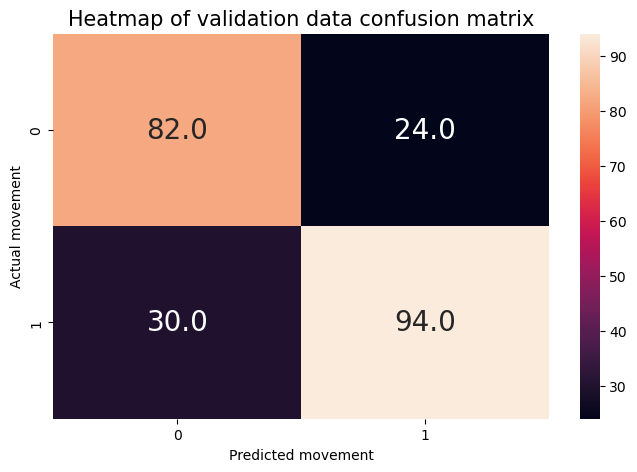

In [97]:
# Predict label with the validation data
y_predict = clf_stack.predict(X_valid)

# Calculate metrics score
print("Accuracy score:", accuracy_score(y_valid, y_predict))   
print("Precision score:",precision_score(y_valid, y_predict))
print("Log_loss:",log_loss(y_valid, clf_stack.predict_proba(X_valid)[:,1])) 
print(f"AUC score: {roc_auc_score(y_valid, clf_stack.predict_proba(X_valid)[:,1])}") 

# Plotting confusion matrix heatmap
cm = confusion_matrix(y_valid, y_predict)
fig, heatmap_cm = plt.subplots(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt=".1f",  ax=heatmap_cm, annot_kws={"fontsize":20})
heatmap_cm.set(xlabel="Predicted movement", ylabel="Actual movement")
heatmap_cm.set_title("Heatmap of validation data confusion matrix", fontsize=15)

In [98]:
# Append predicted labels to date and closing price
back_test = sti_df_validation[["Date","Close","Next_day_movement"]]
back_test["Predict"] = y_predict

C:\Users\User\AppData\Local\Temp\ipykernel_6800\3440699354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  back_test["Predict"] = y_predict


## 5.2 Testing of predicted values in a buy or sell situation

In [99]:
# Simulate buy or sell scenario with prediction from model on 2022 data
current_position = 0 # Start off with no position in market
long_position_prices = [] # To store buy prices and exit prices
short_position_prices = [] # To store sell prices and exit prices
long_position_date = [] # To store buy and exit dates
short_position_date =[] # To store buy and exit dates

for prediction, price, date in zip(back_test["Predict"], back_test["Close"], back_test["Date"]):
    if current_position == 0 and  prediction == 0: # No position with sell prediction
        current_position = -1
        short_position_prices.append(price)
        short_position_date.append(date)

    elif current_position == 0 and  prediction == 1: # No position with buy prediction
        current_position = 1
        long_position_prices.append(price)
        long_position_date.append(date)

    elif current_position == 1 and  prediction == 0: # Currently with long position with sell prediction
        current_position = -1
        long_position_prices.append(price) # Sell current long position
        long_position_prices.append(np.nan)
        long_position_date.append(date)
        long_position_date.append(np.nan)
        short_position_prices.append(price) # Enter new short position
        short_position_date.append(date)

    elif current_position == -1 and  prediction == 1: # Currently with short position with buy prediction
        current_position = 1
        short_position_prices.append(price) # Buy back current short position
        short_position_prices.append(np.nan) 
        short_position_date.append(date)
        short_position_date.append(np.nan)
        long_position_prices.append(price) # Enter new long position
        long_position_date.append(date)      


In [100]:
# Combine long and short dates to prices
short_position = pd.DataFrame()
long_position = pd.DataFrame()
short_position["Date"] = short_position_date
long_position["Date"] = long_position_date
short_position["Price"] = short_position_prices
long_position["Price"] = long_position_prices

In [101]:
# Import libraries for plotting
import plotly.graph_objs as go
import plotly.offline as offline

In [102]:
# Trace for short positions
trace0 = go.Scatter(
    
    x = short_position["Date"],
    y = short_position["Price"],
    
    name = 'Short positions',
    
    line = dict(color = ('red'),
                width = 2)
)

# Trace for short positions
trace1 = go.Scatter(
    
    x = long_position["Date"],
    y = long_position["Price"],
    
    name = 'Long positions',
    
    line = dict(color = ('blue'),
                width = 2)
)

# Trace for closing price
trace2 = go.Scatter(
    
    x = sti_df_validation["Date"],
    y = sti_df_validation["Close"],
    
    name = 'Closing price',
    
    line = dict(color = ('green'),
                width = 1),
)

In [103]:
# Plotting out entry and exits done
data = [trace0, trace1, trace2]

layout = dict(title = 'Backtesting of 2022 data',
              xaxis = dict(title = 'Date'),
              yaxis = dict(title = 'Price'),
              )

fig = dict(data=data, layout=layout)

offline.iplot(fig)


In [104]:
# Finding the profit by finding the difference and filter out by dropping the nan
buy = long_position["Price"].diff().dropna()
sell = short_position["Price"].diff().dropna()*-1 # Change profit to a positive number as it is shorting trades

# Results of total trades perform by buys, sells, total profit
print("Number of trades", len(buy)+len(sell))
print("Number of buy trades is ", len(buy), "and number of sell trades", len(sell))
print("Profit from long positions", buy.sum())
print("Profit from short positions", sell.sum())
print("Total profit", buy.sum() + sell.sum())

Number of trades 50
Number of buy trades is  25 and number of sell trades 25
Profit from long positions 450.0703125
Profit from short positions 307.960205078125
Total profit 758.030517578125
